In [13]:
# packages
import pandas as pd
from tokenizers import *
import os
import json
import sys
# from tokenizers.processors import BertProcessing
import numpy as np
import models
from models import DefectModel

In [5]:
# INPORTANT
# out_dir = './task_devign_v3'
# raw_data_path = '/scratch/xin/devign_task/tokenized_devign_v3.pkl'
# model_path = '/scratch/xin/bert_source_v3/pretrained-bert/'
num_epochs = 1
max_step_saves = 3
save_step_at = 1000
learning_rate = 1e-5
adam_epsilon = 1e-8
early_stop = 10
normalize = 'ReLU'
t5_checkpoint = "t5-base"
test_only = False
data_type = 'devign'

# # redas-lab2
MAX_LENGTH = 512
data_dir = "/scratch/dna_data_vult/"
# vult_model_path = '../pretrained-dna-vult/checkpoint-80'
vult_model_path = 'Salesforce/codet5-base'
tokenizer_path = "Salesforce/codet5-base"
batch_size = 2  # 8GB per GPU   

# # # carya cluster
# MAX_LENGTH = 1024
# data_dir = "../../dna_data_lite_2/{}".format(data_type)
# bert_model_path = '../pretrained-dna-roberta-2/checkpoint-40000'
# tokenizer_path = '../../dna_data_pretraining_2/BPE_tokenizer'
# batch_size = 16 # 32GB per GPU -  max_length 512: 32 -max_length 1024: 16


out_dir = '../result_duo_mode_{}_{}_with_tagging'.format(data_type, MAX_LENGTH)
truncate_longer_samples = True

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
log_txt_file = os.path.join(out_dir, 'log.txt')
# intialization
with open(log_txt_file, 'w+') as f:
    f.write('- log -\n')

def log_txt(s, type='normal'):
    with open(log_txt_file, 'a') as f:
        f.write('{} - {}\n'.format( type, s))

# intial parameters
log_txt('data_type: {}'.format(data_type))
log_txt('data_dir: {}'.format(data_dir))
log_txt('out_dir: {}'.format(out_dir))
# log_txt('bert_model_path: {}'.format(bert_model_path))
log_txt('tokenizer_path: {}'.format(tokenizer_path))
log_txt('MAX_LENGTH: {}'.format(MAX_LENGTH))
log_txt('batch_size: {}'.format(batch_size))
log_txt('num_epochs: {}'.format(num_epochs))
log_txt('save_step_at: {}'.format(save_step_at))
log_txt('learning_rate: {}'.format(learning_rate))
log_txt('adam_epsilon: {}'.format(adam_epsilon))
log_txt('normalize: {}'.format(normalize))
# log_txt('CLASSIFIER_HIDDEN_SIZE: {}'.format(CLASSIFIER_HIDDEN_SIZE))


In [6]:
# load data
from sklearn.model_selection import train_test_split

def get_data(file_path):
    raw_df = pd.read_pickle(file_path)  
    df = {'filename': [], 'code': [], 'nat': [], 'tags': [], 'label': []}
    for i in range(len(raw_df['code'][:100])):
        df['filename'].append(raw_df['filename'][i])
        ## add "Defect: " is required to switch VulT model for specific task
        df['code'].append('Defect: ' + raw_df['code'][i])
        df['nat'].append('Defect: ' +raw_df['nat'][i])
        df['tags'].append('Defect: ' +raw_df['tags'][i])
        df['label'].append(raw_df['label'][i])
        
    df = pd.DataFrame(df)
    return df
    ### convert to Huggingface dataset
#     return Dataset(pa.Table.from_pandas(df))

# random split into train/valid/test
if data_type in ['devign']:
    train_data = get_data(os.path.join(data_dir, 'devign_train.pkl'))
    valid_data = get_data(os.path.join(data_dir, 'devign_valid.pkl'))
    test_data = get_data(os.path.join(data_dir, 'devign_test.pkl'))
# # load train/valid/test
# elif data_type in ['mvdsc', 'd2a' ]:
#     train_data = get_data(os.path.join(data_dir, 'train.pkl'))
#     valid_data = get_data(os.path.join(data_dir, 'valid.pkl'))
#     test_data = get_data(os.path.join(data_dir, 'test.pkl'))
# # load train/valid/test from 4 types
# elif data_type in ['sysevr']:
#     # already randomized from pre-processing with fixed seed for pre-training and fine-tuning
#     raw_data_path = os.path.join(data_dir, 'api.pkl')
#     tokenized_data = get_data(raw_data_path)
#     train_data_1, valid_data_1, test_data_1 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
#     raw_data_path = os.path.join(data_dir, 'au.pkl')
#     tokenized_data = get_data(raw_data_path)
#     train_data_2, valid_data_2, test_data_2 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
#     raw_data_path = os.path.join(data_dir, 'ae.pkl')
#     tokenized_data = get_data(raw_data_path)
#     train_data_3, valid_data_3, test_data_3 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
#     raw_data_path = os.path.join(data_dir, 'pu.pkl')
#     tokenized_data = get_data(raw_data_path)
#     train_data_4, valid_data_4, test_data_4 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
#     tokenized_data = get_data(raw_data_path)
#     train_data = pd.concat([train_data_1, train_data_2, train_data_3, train_data_4], ignore_index=True)
#     valid_data = pd.concat([valid_data_1, valid_data_2, valid_data_3, valid_data_4], ignore_index=True)
#     test_data = pd.concat([test_data_1, test_data_2, test_data_3, test_data_4], ignore_index=True)
# elif  data_type in ['draper']:
#     # splitted data bc too large
#     all_data = {}
#     for i in range(10):
#         raw_data_path = os.path.join(data_dir, 'train_{}.pkl'.format(i))
#         tokenized_data = get_data(raw_data_path)
#         #train_data = pd.concat([train_data_1, train_data_2, train_data_3, train_data_4], ignore_index=True)

else:
    print('data type does not exist!')


In [9]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
# print(train_data['code'][:3])
log_txt('train: {} - valid: {} - test: {} '.format(len(train_data), len(valid_data), len(test_data)))
train_data['code'][0]

(100, 5)
(100, 5)
(100, 5)


'Defect: static uint32_t sh_serial_ioport_read(void *opaque, uint32_t offs) newline { newline sh_serial_state *s = opaque; newline uint32_t ret = ~0; newline #if 0 newline switch(offs) { newline case 0x00: newline ret = s->smr; newline break; newline case 0x04: newline ret = s->brr; newline break; newline case 0x08: newline ret = s->scr; newline break; newline case 0x14: newline ret = 0; newline break; newline } newline #endif newline if (s->feat & SH_SERIAL_FEAT_SCIF) { newline switch(offs) { newline case 0x00: /* SMR */ newline ret = s->smr; newline break; newline case 0x08: /* SCR */ newline ret = s->scr; newline break; newline case 0x10: /* FSR */ newline ret = 0; newline if (s->flags & SH_SERIAL_FLAG_TEND) newline ret |= (1 << 6); newline if (s->flags & SH_SERIAL_FLAG_TDE) newline ret |= (1 << 5); newline if (s->flags & SH_SERIAL_FLAG_BRK) newline ret |= (1 << 4); newline if (s->flags & SH_SERIAL_FLAG_RDF) newline ret |= (1 << 1); newline if (s->flags & SH_SERIAL_FLAG_DR) newline 

In [10]:
train_code = train_data['code'].values
train_nat = train_data['nat'].values
train_tags = train_data['tags'].values
train_labels = train_data['label'].values

valid_code = valid_data['code'].values
valid_nat = valid_data['nat'].values
valid_tags = valid_data['tags'].values
valid_labels = valid_data['label'].values

test_code = test_data['code'].values
test_nat = test_data['nat'].values
test_tags = test_data['tags'].values
test_labels = test_data['label'].values


In [11]:
import statistics
train_texts = train_code
log_txt('---------- train_code ---------------')
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
log_txt('min: {}'.format(min(text_lengths)))
log_txt('min: {}'.format(min(text_lengths)))
log_txt('number of zeros:: {}'.format(len([item for item in text_lengths if item == 0])))
log_txt('max: {}'.format(max(sorted(text_lengths))))
log_txt('avg: {}'.format( sum(text_lengths) / len(text_lengths) ))
log_txt('median: {}'.format( sorted(text_lengths)[len(text_lengths) // 2] ))
log_txt('95%: {}'.format( sorted(text_lengths)[int(len(text_lengths)*0.95)]))
log_txt('mean: {}'.format( statistics.mean(text_lengths)))
log_txt('std: {}'.format( statistics.stdev(text_lengths)))

train_texts = train_nat
log_txt('---------- train_nat ---------------')
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
log_txt('min: {}'.format(min(text_lengths)))
log_txt('min: {}'.format(min(text_lengths)))
log_txt('number of zeros:: {}'.format(len([item for item in text_lengths if item == 0])))
log_txt('max: {}'.format(max(sorted(text_lengths))))
log_txt('avg: {}'.format( sum(text_lengths) / len(text_lengths) ))
log_txt('median: {}'.format( sorted(text_lengths)[len(text_lengths) // 2] ))
log_txt('95%: {}'.format( sorted(text_lengths)[int(len(text_lengths)*0.95)]))
log_txt('mean: {}'.format( statistics.mean(text_lengths)))
log_txt('std: {}'.format( statistics.stdev(text_lengths)))


train_texts = train_tags
log_txt('---------- train_tags ---------------')
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
log_txt('min: {}'.format(min(text_lengths)))
log_txt('min: {}'.format(min(text_lengths)))
log_txt('number of zeros:: {}'.format(len([item for item in text_lengths if item == 0])))
log_txt('max: {}'.format(max(sorted(text_lengths))))
log_txt('avg: {}'.format( sum(text_lengths) / len(text_lengths) ))
log_txt('median: {}'.format( sorted(text_lengths)[len(text_lengths) // 2] ))
log_txt('95%: {}'.format( sorted(text_lengths)[int(len(text_lengths)*0.95)]))
log_txt('mean: {}'.format( statistics.mean(text_lengths)))
log_txt('std: {}'.format( statistics.stdev(text_lengths)))
    

/tmp/ipykernel_28983/280788245.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_lengths, hist=True, kde=False,


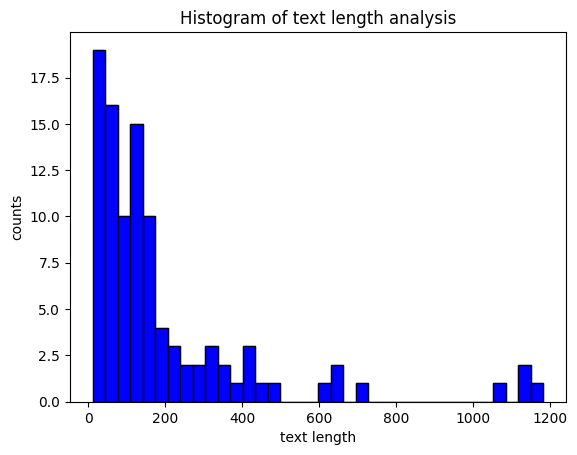

In [12]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib histogram
plt.hist(text_lengths, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# seaborn histogram
sns.distplot(text_lengths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of text length analysis')
plt.xlabel('text length')
plt.ylabel('counts')
plt.savefig(os.path.join(out_dir, 'histogram.png'))

In [14]:
# ========================= load tokenizer START =========================
# 30,522 vocab is BERT's default vocab size, feel free to tweak
# vocab_size = 32010
# maximum sequence length, lowering will result to faster training (when increasing batch size)
import sentencepiece as spm
import transformers 
# !pip install sentencepiece
print(tokenizer_path)
from tokenizers import SentencePieceBPETokenizer

if 'codet5' in tokenizer_path:
    tokenizer = transformers.RobertaTokenizer.from_pretrained(tokenizer_path)
elif 'albert' in tokenizer_path:
    tokenizer = transformers.AlbertTokenizer.from_pretrained(tokenizer_path)
else:
    tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_path)

log_txt('tokenizer_path: {}\n'.format( tokenizer_path))


Salesforce/codet5-base


In [49]:
# def preprocess_function(examples):
#     model_inputs = tokenizer(examples["text"], max_length=max_length, padding=True, truncation=True)
#     # Setup the tokenizer for targets
#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer(examples["label"], max_length=max_length, padding=True, truncation=True)
#     model_inputs["decoder_input_ids"] = labels["input_ids"]
#     model_inputs["decoder_attention_mask"] = labels["attention_mask"]    
#     # model_inputs["labels"] =  labels["input_ids"]
#     return model_inputs

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
##### train data
train_code_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in train_code]
train_nat_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in train_nat]
train_tags_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in train_tags]
train_code_ids = [text_id['input_ids'] for text_id in train_code_dict]
train_code_masks = [text_id['attention_mask'] for text_id in train_code_dict]
train_nat_ids = [text_id['input_ids'] for text_id in train_nat_dict]
train_nat_masks = [text_id['attention_mask'] for text_id in train_nat_dict]
train_tag_ids = [text_id['input_ids'] for text_id in train_tags_dict]
train_tag_masks = [text_id['attention_mask'] for text_id in train_tags_dict]

train_x1, train_m1, train_x2, train_m2, train_x3, train_m3, train_y = train_code_ids, train_code_masks, train_nat_ids, train_nat_masks, train_tag_ids, train_tag_masks, train_labels
train_x1 = torch.tensor(train_x1)
train_m1 = torch.tensor(train_m1)
train_x2 = torch.tensor(train_x2)
train_m2 = torch.tensor(train_m2)
train_x3 = torch.tensor(train_x3)
train_m3 = torch.tensor(train_m3)
train_y = torch.tensor(train_y)

train_data = TensorDataset(train_x1, train_m1, train_x2, train_m2, train_x3, train_m3, train_y)
train_sampler = list(range(len(train_data)))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
#### valid data
valid_code_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in valid_code]
valid_nat_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in valid_nat]
valid_tags_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in valid_tags]
valid_code_ids = [text_id['input_ids'] for text_id in valid_code_dict]
valid_code_masks = [text_id['attention_mask'] for text_id in valid_code_dict]
valid_nat_ids = [text_id['input_ids'] for text_id in valid_nat_dict]
valid_nat_masks = [text_id['attention_mask'] for text_id in valid_nat_dict]
valid_tag_ids = [text_id['input_ids'] for text_id in valid_tags_dict]
valid_tag_masks = [text_id['attention_mask'] for text_id in valid_tags_dict]

valid_x1, valid_m1, valid_x2, valid_m2, valid_x3, valid_m3, valid_y = valid_code_ids, valid_code_masks, valid_nat_ids, valid_nat_masks, valid_tag_ids, valid_tag_masks, valid_labels
valid_x1 = torch.tensor(valid_x1)
valid_m1 = torch.tensor(valid_m1)
valid_x2 = torch.tensor(valid_x2)
valid_m2 = torch.tensor(valid_m2)
valid_x3 = torch.tensor(valid_x3)
valid_m3 = torch.tensor(valid_m3)
valid_y = torch.tensor(valid_y)

valid_data = TensorDataset(valid_x1, valid_m1, valid_x2, valid_m2, valid_x3, valid_m3, valid_y)
valid_sampler = list(range(len(valid_data)))
valid_sampler = RandomSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

#### test data
test_code_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in test_code]
test_nat_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in test_nat]
test_tags_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in test_tags]
test_code_ids = [text_id['input_ids'] for text_id in test_code_dict]
test_code_masks = [text_id['attention_mask'] for text_id in test_code_dict]
test_nat_ids = [text_id['input_ids'] for text_id in test_nat_dict]
test_nat_masks = [text_id['attention_mask'] for text_id in test_nat_dict]
test_tag_ids = [text_id['input_ids'] for text_id in test_tags_dict]
test_tag_masks = [text_id['attention_mask'] for text_id in test_tags_dict]

test_x1, test_m1, test_x2, test_m2, test_x3, test_m3, test_y = test_code_ids, test_code_masks, test_nat_ids, test_nat_masks, test_tag_ids, test_tag_masks, test_labels
test_x1 = torch.tensor(test_x1)
test_m1 = torch.tensor(test_m1)
test_x2 = torch.tensor(test_x2)
test_m2 = torch.tensor(test_m2)
test_x3 = torch.tensor(test_x3)
test_m3 = torch.tensor(test_m3)
test_y = torch.tensor(test_y)

test_data = TensorDataset(test_x1, test_m1, test_x2, test_m2, test_x3, test_m3, test_y)
test_sampler = list(range(len(test_data)))
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [51]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import sys

class VulT6_Classifier(nn.Module):
    def __init__(self, encoder, tokenizer, config, num_labels): 
        super(VulT6_Classifier,self).__init__() 
        self.num_labels = num_labels 
        self.encoder = encoder
        self.tokenizer = tokenizer
        self.config = config
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        
    def get_t5_vec(self, source_ids, attention_mask):
        outputs = self.encoder(input_ids=source_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs['decoder_hidden_states'][-1]
        eos_mask = source_ids.eq(self.config.eos_token_id)
        if len(torch.unique(eos_mask.sum(1))) > 1:
            raise ValueError("All examples must have the same number of <eos> tokens.")
        vec = hidden_states[eos_mask, :].view(hidden_states.size(0), -1,
                                              hidden_states.size(-1))[:, -1, :]
        return vec
    
    def forward(self, x1, m1, x2, m2, x3, m3, labels=None):
        vec_1 = self.get_t5_vec(x1, m1)
        # batch_size x 768 (hidden_size)
        # print(vec_code.shape)
        
        logits = self.classifier(vec_1)
        prob = nn.functional.softmax(logits)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            
        return (loss, prob), None
        #return (loss, final_logits), final_attention_weights



In [52]:
log_txt(vult_model_path)
encoder_model = transformers.T5ForConditionalGeneration.from_pretrained(vult_model_path)
model_config = transformers.T5Config.from_pretrained(vult_model_path)    

model = VulT6_Classifier(encoder_model, tokenizer, model_config, 2)


In [53]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)


os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
multi_gpu = torch.cuda.device_count() 
if multi_gpu > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
# model = nn.DataParallel(model)
model = model.cuda()


from transformers import get_linear_schedule_with_warmup
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=2, num_training_steps=total_steps)


Let's use 4 GPUs!


In [54]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import numpy as np
import random

seed_val = 111
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
import pickle
import os
# save model 
def save_model(model, train_losses, val_losses, out_dir_model):
    if not os.path.exists(out_dir_model):
        os.makedirs(out_dir_model)
    PATH = os.path.join(out_dir_model, 'VulTBinaryClassification.pt')
    torch.save(model.state_dict(), PATH)
    with open(out_dir_model + '/train_losses.pkl', 'wb') as f:
        pickle.dump(train_losses, f)
    with open(out_dir_model + '/val_losses.pkl', 'wb') as f:
        pickle.dump(val_losses, f)
print('number of iterations: ', len(train_dataloader))

number of iterations:  250


In [ ]:
if not test_only:
    from tqdm import tqdm
    train_losses = []
    val_losses = []
    num_mb_train = len(train_dataloader)
    num_mb_val = len(valid_dataloader)
    current_step = 0
    saved_steps = []
    if num_mb_val == 0:
        num_mb_val = 1

    # print('number of iterations: ', len(train_dataloader), len(train_loader_extracted))
    print('num_epochs: ', num_epochs)

    loss_fct = nn.CrossEntropyLoss()


    for n in range(num_epochs):
        train_loss = 0
        val_loss = 0
        start_time = time.time()

        #for k, (data1, data2) in enumerate(zip(train_dataloader, train_loader_extracted)):
        for k, (x1, m1, x2, m2, x3, m3, y) in tqdm(enumerate(train_dataloader)):
            #mb_x, mb_m, mb_y = data1
            # 56 features
            #ex, ey, e_index = data2
            optimizer.zero_grad()
            model.train()
            x1 = x1.cuda()
            m1 = m1.cuda()
            x2 = x2.cuda()
            m2 = m2.cuda()
            x3 = x3.cuda()
            m3 = m3.cuda()
            y = y.cuda()
            outputs, _, = model(x1, m1, x2, m2, x3, m3, labels=y)
            loss = outputs[0]
            # logits = outputs[1]
            if multi_gpu > 1:
                loss = loss.sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            current_step += 1
            train_loss += loss.data / num_mb_train

            if current_step % save_step_at == 0:
                saved_steps.append(current_step)
                out_dir_model = os.path.join(out_dir, 'classification_model_{}'.format(saved_steps[-1]) )
                print('saved as: ', out_dir_model)
                if len(saved_steps) > max_step_saves:
                    delete_dir = os.path.join(out_dir, 'classification_model_{}'.format(saved_steps[-(max_step_saves+1)]))
                    os.system('rm -r {}'.format(delete_dir))
                save_model(model, train_losses, val_losses, out_dir_model)


        print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
        train_losses.append(train_loss.cpu())

        with torch.no_grad():
            model.eval()

            for k, (x1, m1, x2, m2, x3, m3, y) in tqdm(enumerate(valid_dataloader)):
                x1 = x1.cuda()
                m1 = m1.cuda()
                x2 = x2.cuda()
                m2 = m2.cuda()
                x3 = x3.cuda()
                m3 = m3.cuda()
                y = y.cuda()
                outputs, _, = model(x1, m1, x2, m2, x3, m3, labels=y)
                
                loss = outputs[0]
                if multi_gpu > 1:
                    loss = loss.sum()
                #loss = model_loss(outputs[1], mb_y)

                val_loss += loss.data / num_mb_val

            print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
            # save the best

            print('val_losses: ', val_losses, float(val_loss.cpu()))
            if val_losses and float(val_loss.cpu()) <= min(val_losses):
                out_dir_model = os.path.join(out_dir, 'classification_model_best')
                print('the best model updated')
                print('saved as: ', out_dir_model)
                save_model(model, train_losses, val_losses, out_dir_model)
            val_losses.append(float(val_loss.cpu()))

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        if len(val_losses) > 3 and float(val_loss.cpu()) > max(val_losses[-4:-1]):
            break


    out_dir_model = os.path.join(out_dir, 'classification_model_last')
    save_model(model, train_losses, val_losses, out_dir_model)
    print('model saved as: ', out_dir_model)

num_epochs:  3


0it [00:00, ?it/s]/tmp/ipykernel_604/1081882820.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = nn.functional.softmax(logits)
/scratch/conda_envs/dna/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
250it [06:51,  1.65s/it]



Train loss after itaration 1: 3.620058


250it [02:16,  1.83it/s]


Validation loss after itaration 1: 2.425647
val_losses:  [] 2.4256465435028076
Time: 9m 8s


32it [00:52,  1.63s/it]

In [ ]:

# out_dir_model = '{}/classification_model_4000'.format(out_dir)

test_dir_model = '{}/classification_model_last'.format(out_dir)

PATH = os.path.join(test_dir_model, 'VulTBinaryClassification.pt')
model.load_state_dict(torch.load(PATH))
model.eval()

with open(test_dir_model + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(test_dir_model + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

print(val_losses)
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.savefig(os.path.join(out_dir, 'train_valid_loss.png'))

In [ ]:
outputs = []
print('num of iterations: ', len(test_dataloader))
with torch.no_grad():
    for k, (x1, m1, x2, m2, x3, m3, y) in tqdm(enumerate(test_dataloader)):
        x1 = x1.cuda()
        m1 = m1.cuda()
        x2 = x2.cuda()
        m2 = m2.cuda()
        x3 = x3.cuda()
        m3 = m3.cuda()
        y = y.cuda()
        output, _, = model(x1, m1, x2, m2, x3, m3, labels=y)
        outputs.append(output[1].to('cpu'))
outputs = torch.cat(outputs)

In [ ]:
print(outputs[:10])
print(test_y[:10])
true_values = test_y.numpy()
################################################
## OPTIONAL: to find best detection threshold ##
results = []
for i in range(100):
    prediction_probs = outputs[:,1]
    detection_threshold = i / 100
    predictions = [1 if x >= detection_threshold else 0 for x in list(prediction_probs)]
    test_accuracy = np.sum(predictions == true_values) / len(true_values)
    results.append(test_accuracy)
results = sorted(results)
print('lowest: ', results[:5])
print('highest: ', results[-5:])
################################################

preds = outputs[:, 1] > 0.5
eval_acc = np.mean(true_values == preds)
print ("Test Accuracy - eval_acc: ", eval_acc)

_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)
log_txt("Test Accuracy: {}".format(test_accuracy))


In [ ]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
label_values = [0, 1]
def confusion_matrix_scorer(y_pred, y):
    cm = metrics.confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
        'fn': cm[1, 0], 'tp': cm[1, 1]}

cm_test = metrics.confusion_matrix(true_values, predicted_values)
print({ 'tn': cm_test[0, 0], 'fp': cm_test[0, 1],
        'fn': cm_test[1, 0], 'tp': cm_test[1, 1]})

log_txt('tn: {} - fp: {} - fn: {} - tp: {}'.format(cm_test[0, 0], cm_test[0, 1], cm_test[1, 0], cm_test[1, 1]))
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')

plt.savefig(os.path.join(out_dir, 'confusion_matrix.png'))

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)

plt.savefig(os.path.join(out_dir, 'confusion_matrix_normalized.png'))